In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from C_0B_eval import *
from C_0X_defs import *
from scipy.stats import sem, ttest_ind

In [8]:
def read_result_at(res_save_dir, epoch): 
    all_handler = DictResHandler(whole_res_dir=res_save_dir, 
                                 file_prefix=f"all-{epoch}")

    all_handler.read()

    return all_handler.res

def calculate_means_and_sems(values):
    """Calculates means and standard errors of the means (SEMs) for input values."""
    return np.mean(values), sem(values)

In [20]:
def plot_attention_epoch_trajectory(all_phi_type, all_attn, all_sepframes1, all_sepframes2, save_path): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    legend_namess = [['S-to-P', 'P-to-S', 'P-to-V', 'V-to-P'], ['#-to-P', 'P-to-#', 'P-to-V', 'V-to-P']]
    colors = ['b', 'g', 'red', 'orange']
    n_steps = 100
    segment_length = int(n_steps * 0.1)  # Calculate 20% segment length
    badcounts = {"ST": 0, "T": 0}
    totalcounts = {"ST": 0, "T": 0}

    for (selector, ax, legend_names) in zip(["ST", "T"], [ax1, ax2], legend_namess):
        # 这个只是处理ST和T，而非循环
        meanslist = []
        upperlist = []
        lowerlist = []
        for epoch in range(len(all_attn)): 
            # 循环每个epoch
            phi_type_epoch = all_phi_type[epoch]
            attn_epoch = all_attn[epoch]
            sepframes1_epoch = all_sepframes1[epoch]
            sepframes2_epoch = all_sepframes2[epoch]
            selected_tuples = [(sf1, sf2, attn) for pt, sf1, sf2, attn in zip(phi_type_epoch,  
                                                            sepframes1_epoch, 
                                                            sepframes2_epoch, 
                                                            attn_epoch) if pt == selector]
            selected_sf1s_epoch, selected_sf2s_epoch, selected_attns_epoch = zip(*selected_tuples)
            s_to_t_traj = []
            t_to_s_traj = []
            t_to_a_traj = []
            a_to_t_traj = []

            totalcounts[selector] += len(selected_attns_epoch)
        
            for i in range(len(selected_attns_epoch)): 
                # 循环每个run
                this_attn = selected_attns_epoch[i]
                # this_sep_frame0 = selected_sf0s_epoch[i]
                this_sep_frame1 = selected_sf1s_epoch[i]
                this_sep_frame2 = selected_sf2s_epoch[i]

                if selector == "ST": 
                    blocks = extract_attention_blocks_ST(this_attn, this_sep_frame1, this_sep_frame2)
                elif selector == "T": 
                    blocks = extract_attention_blocks_ST(this_attn, this_sep_frame1, this_sep_frame2)
                else: 
                    raise ValueError("selector must be ST or T")

                # s_to_t_interp = interpolate_traj(blocks['s_to_t'], n_steps)
                # t_to_s_interp = interpolate_traj(blocks['t_to_s'], n_steps)
                # t_to_a_interp = interpolate_traj(blocks['t_to_a'], n_steps)
                # a_to_t_interp = interpolate_traj(blocks['a_to_t'], n_steps)
                s_to_t_interp = blocks['s_to_t']
                t_to_s_interp = blocks['t_to_s']
                t_to_a_interp = blocks['t_to_a']
                a_to_t_interp = blocks['a_to_t']

                if np.any(np.isnan(s_to_t_interp)) or np.any(np.isnan(t_to_s_interp)) or np.any(np.isnan(t_to_a_interp)) or np.any(np.isnan(a_to_t_interp)):
                    badcounts[selector] += 1
                    # print(f"NAN at {epoch} in run {i} for {selector}")
                    continue
                s_to_t_traj.append(s_to_t_interp[-1])
                t_to_s_traj.append(t_to_s_interp[0])
                t_to_a_traj.append(t_to_a_interp[-1])
                a_to_t_traj.append(a_to_t_interp[0])

            # Convert list of arrays into 2D NumPy arrays for easier manipulation
            group1_array = np.array(s_to_t_traj)
            group2_array = np.array(t_to_s_traj)
            group3_array = np.array(t_to_a_traj)
            group4_array = np.array(a_to_t_traj)

            target_group1 = group1_array.flatten()
            target_group2 = group2_array.flatten()
            target_group3 = group3_array.flatten()
            target_group4 = group4_array.flatten()

            # Calculate the mean trajectory for each group
            means = np.array([np.mean(target_group1, axis=0), 
                            np.mean(target_group2, axis=0), 
                            np.mean(target_group3, axis=0), 
                            np.mean(target_group4, axis=0)])

            # Calculate the SEM for each step in both groups
            sems = np.array([sem(target_group1, axis=0),
                            sem(target_group2, axis=0),
                            sem(target_group3, axis=0),
                            sem(target_group4, axis=0)])

            # Calculate the 95% CI for both groups
            ci_95s = 10.96 * sems

            # Upper and lower bounds of the 95% CI for both groups
            upper_bounds = means + ci_95s
            lower_bounds = means - ci_95s

            meanslist.append(means)
            upperlist.append(upper_bounds)
            lowerlist.append(lower_bounds)

        means = np.array(meanslist)
        upper_bounds = np.array(upperlist)
        lower_bounds = np.array(lowerlist)
        means = means.T
        upper_bounds = upper_bounds.T
        lower_bounds = lower_bounds.T
        print(means.shape, upper_bounds.shape, lower_bounds.shape)
        num_epochs = 100
        for mean, upper, lower, label, c in zip(means, upper_bounds, lower_bounds, legend_names, colors):
            ax.plot(mean, label=label, color=c)
            ax.fill_between(range(len(mean)), lower, upper, alpha=0.2, color=c)
        ax.set_xlabel('Normalized Time')
        ax.set_ylabel('Summed Foreign-Attention')
        ax.set_title(f'{selector}')
        ax.set_ylim([0, 1])
        ax.legend(loc = "upper left")
        ax.grid(True)

    print(f"badcounts: {badcounts}")
    print(f"totalcounts: {totalcounts}")
    fig.suptitle('Comparison of Foreign-Attention Trajectory')
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    plt.close()


Processing recon8-phi at 0...
Processing recon8-phi at 1...
Processing recon8-phi at 2...
Processing recon8-phi at 3...
Processing recon8-phi at 4...
Processing recon8-phi at 5...
Processing recon8-phi at 6...
Processing recon8-phi at 7...
Processing recon8-phi at 8...
Processing recon8-phi at 9...
Processing recon8-phi at 10...
Processing recon8-phi at 11...
Processing recon8-phi at 12...
Processing recon8-phi at 13...
Processing recon8-phi at 14...
Processing recon8-phi at 15...
Processing recon8-phi at 16...
Processing recon8-phi at 17...
Processing recon8-phi at 18...
Processing recon8-phi at 19...
Processing recon8-phi at 20...
Processing recon8-phi at 21...
Processing recon8-phi at 22...
Processing recon8-phi at 23...
Processing recon8-phi at 24...
Processing recon8-phi at 25...
Processing recon8-phi at 26...
Processing recon8-phi at 27...
Processing recon8-phi at 28...
Processing recon8-phi at 29...
Processing recon8-phi at 30...
Processing recon8-phi at 31...
Processing recon8-

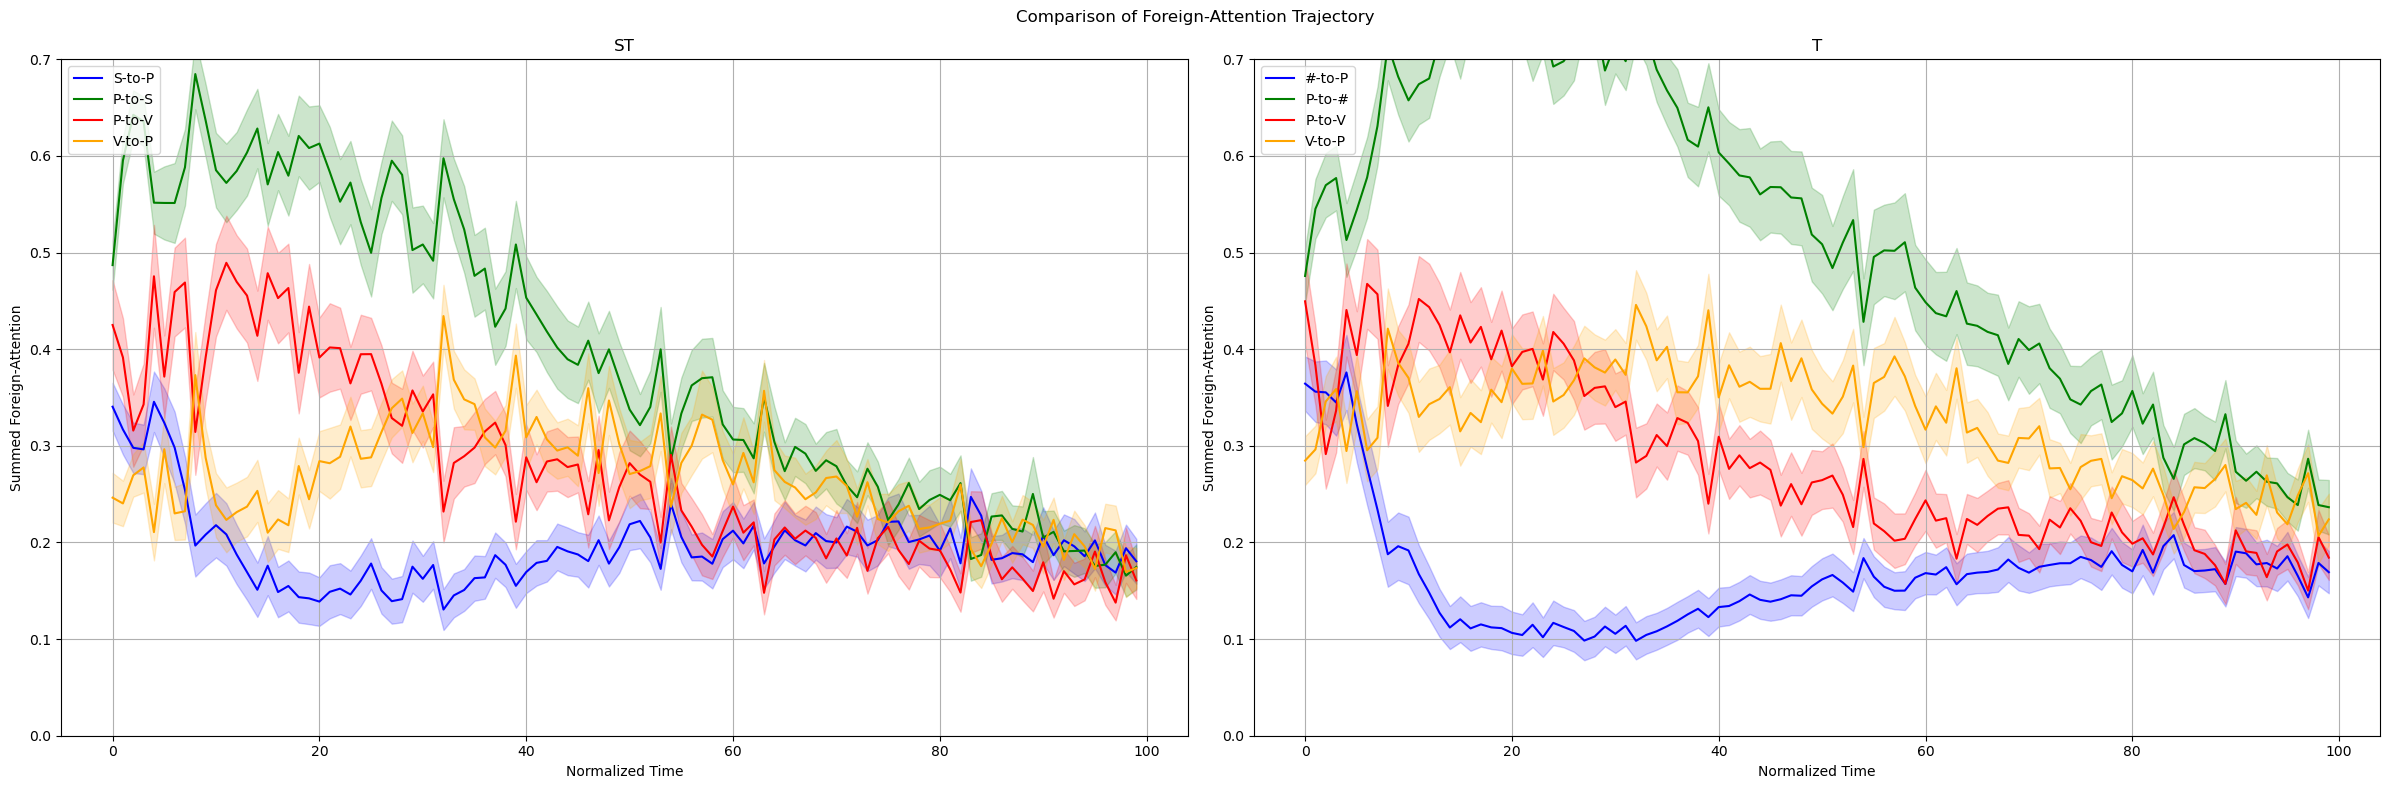

: 

In [21]:
ts = "0611193546" # this timestamp does not contain run number
model_type = "recon8-phi"
model_condition = "u"
train_name = "C_0T"
res_save_dir = os.path.join(model_save_, f"eval-{train_name}-{ts}")

sil_dict = {}
model_condition_dir = os.path.join(res_save_dir, model_type, model_condition)
assert PU.path_exist(model_condition_dir)
this_save_dir = os.path.join(model_condition_dir, "integrated_results")
mk(this_save_dir)

every_attns = []
# every_sepframes0 = []
every_sepframes1 = []
every_sepframes2 = []
every_phi_types = []

learned_runs = [1, 2, 3, 4, 5]
string_learned_runs = [str(num) for num in learned_runs]
strseq_learned_runs = "".join(string_learned_runs)

for epoch in range(0, 100): 
    cat_attns = []
    # cat_sepframes0 = []
    cat_sepframes1 = []
    cat_sepframes2 = []
    cat_phi_types = []
    print(f"Processing {model_type} at {epoch}...")

    for run_number in learned_runs:
        this_model_condition_dir = os.path.join(model_condition_dir, f"{run_number}")
        allres = read_result_at(this_model_condition_dir, epoch)
        cat_phi_types += allres["phi-type"]
        cat_attns += allres["attn"]
        # cat_sepframes0 += allres["sep-frame0"]
        cat_sepframes1 += allres["sep-frame1"]
        cat_sepframes2 += allres["sep-frame2"]

    # plot_attention_comparison(cat_phi_types, cat_attns, cat_sepframes1, cat_sepframes2, os.path.join(this_save_dir, f"attncomp-at-{epoch}.png"))
    every_attns.append(cat_attns)
    # every_sepframes0.append(cat_sepframes0)
    every_sepframes1.append(cat_sepframes1)
    every_sepframes2.append(cat_sepframes2)
    every_phi_types.append(cat_phi_types)    
plot_attention_epoch_trajectory(every_phi_types, every_attns, every_sepframes1, every_sepframes2, os.path.join(res_save_dir, f"attnepochtraj-at-all-{model_type}-{model_condition}-{strseq_learned_runs}-10pc.png"))

# print("Done.")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (453200,) + inhomogeneous part.